In [ ]:
import os
from os import path

import geopandas as gpd
import matplotlib.pyplot as plt
import momepy
import numpy as np
import pandas as pd
import pylandstats as pls
import rasterio
from rasterio import mask
from rasterstats import zonal_stats
from tqdm.notebook import tqdm

In [ ]:
dest_dir = "data/output/"
dest_temp_dir = "data/temp/pylandstats/"
input_dir = "data/temp/"

## Landscape metrics: Raster zonal stats for buffer areas

In [ ]:
# Set reference polygon layer (buffer areas) for zonal statistics
aggr_poly_gdf = gpd.read_file(path.join(input_dir, "AGGR_DHS_buffer.shp"))

### Pylandstats (lancover patch morphology) in buffer areas

In [ ]:
# ANALYZE LAND COVER CLASSES WITH PYLANDSTATS

# Input raster (with 16 built-up classes)

input_rasterpath = path.join(
    input_dir, "ESACCI-LC-L4-LCCS-Map-300m-P1Y-2012-v2.0.7_rclass16.tif"
)

# Fragment raster into pixel units (for faster calculus with pylandstats)

print("fragmenting raster...")
temp_filepaths = []

with rasterio.open(input_rasterpath) as src:
    meta = src.meta.copy()
    for un_identifier, geom in tqdm(
        zip(aggr_poly_gdf["v001"], aggr_poly_gdf["geometry"]),
        total=aggr_poly_gdf.shape[0],
    ):
        out_image, out_transform = mask.mask(
            src, [geom], crop=True
        )  # returns array with band values
        meta.update(
            {
                "height": out_image.shape[1],
                "width": out_image.shape[2],
                "transform": out_transform,
            }
        )
        temp_filepath = path.join(dest_temp_dir, str(un_identifier) + ".tif")
        with rasterio.open(temp_filepath, "w", **meta) as dst:
            dst.write(out_image[0], 1)
        temp_filepaths.append(temp_filepath)

print("raster fragmented")

# Calculate landscape metrics with pylandstats:

# Create empty dataframe (columns = all raster classes)
print("calculating landscape metrics...")
df = pd.DataFrame()

for filepath in tqdm(temp_filepaths):
    ls = pls.Landscape(filepath)
    class_metrics_df = ls.compute_class_metrics_df(
        metrics=["proportion_of_landscape", "edge_density", "fractal_dimension_am"]
    )
    df = df.append(class_metrics_df.stack(), ignore_index=True)
df = df.fillna(0)
df = df.rename(columns=lambda col: col[1][:4] + "_" + str(col[0]))
print("landscape metrics calculated")

# Remove attributes resulting of erroneous built-up raster class ('190')
df_col_list50 = list(df.columns[df.columns.str.endswith("_190")])
df_c = df.drop(columns=df_col_list50)

# Join dataframe to geodataframe
print("joining and saving temp gdf...")
gdf_final = pd.concat([aggr_poly_gdf, df_c], axis=1)
print("joined")
gdf_final.to_file(path.join(input_dir, "AGGR_DHS_buffer_temp_1.shp"))
print("temp gdf saved")

# remove temp .tif files:
print("removing temp .tifs...")
for filepath in tqdm(temp_filepaths):
    os.remove(filepath)
print("temp .tifs removed")

fragmenting raster...


  0%|          | 0/341 [00:00<?, ?it/s]

raster fragmented
calculating landscape metrics...


  0%|          | 0/341 [00:00<?, ?it/s]

landscape metrics calculated
joining and saving temp gdf...
joined
temp gdf saved
removing temp .tifs...


  0%|          | 0/341 [00:00<?, ?it/s]

temp .tifs removed


In [ ]:
# Check results

with rasterio.open(input_rasterpath) as src:
    src_array = src.read(1)
print("number of classes in raster:", len(np.unique(src_array)))
print("list of classes in raster", np.unique(src_array))
print("number of columns in df:", len(df.columns.to_list()))
if (len(df.columns.to_list())) != ((len(np.unique(src_array)) - 1) * 3):
    print(
        "error: check n° columns in df, should be:", (len(np.unique(src_array)) - 1) * 3
    )
else:
    print("n° columns in df OK")
print("list of cols in df:", df.columns.to_list())
print("columns dropped (class 190):", df_col_list50)
print("aggr_poly_gdf columns:", aggr_poly_gdf.shape[1])
print("df_c columns (to join):", df_c.shape[1])
print("gdf_final columns:", gdf_final.shape[1])
print(src.meta)

# Count pixels with band value = '190'
# >> these pixels are those with a missing value either for density or illumination
# >> therefore have not been reclassified (so kept band value of '190')
# >> The number should be 4 (see notebook 1, preprocessing)
print(
    np.unique(src_array, return_counts=True)[1][list(np.unique(src_array)).index(190)]
)

number of classes in raster: 34
list of classes in raster [    0    10    11    20    30    40    50    60    62   100   110   120
   122   130   160   170   180   190   210 19011 19012 19013 19014 19021
 19022 19023 19024 19031 19032 19033 19034 19042 19043 19044]
number of columns in df: 99
n° columns in df OK
list of cols in df: ['prop_10', 'edge_10', 'frac_10', 'prop_30', 'edge_30', 'frac_30', 'prop_50', 'edge_50', 'frac_50', 'prop_19021', 'edge_19021', 'frac_19021', 'prop_19022', 'edge_19022', 'frac_19022', 'edge_11', 'frac_11', 'prop_11', 'edge_40', 'frac_40', 'prop_40', 'edge_62', 'frac_62', 'prop_62', 'edge_100', 'frac_100', 'prop_100', 'edge_120', 'frac_120', 'prop_120', 'edge_19033', 'frac_19033', 'prop_19033', 'edge_19034', 'frac_19034', 'prop_19034', 'edge_19011', 'frac_19011', 'prop_19011', 'edge_122', 'frac_122', 'prop_122', 'edge_19032', 'frac_19032', 'prop_19032', 'edge_19012', 'frac_19012', 'prop_19012', 'edge_160', 'frac_160', 'prop_160', 'edge_210', 'frac_210', 'prop

In [ ]:
# New round of pylandstats with simplified land cover (non-categorized built up class)

# Input raster (single built-up class, '190')

input_rasterpath = path.join(
    input_dir, "ESACCI-LC-L4-LCCS-Map-300m-P1Y-2012-v2.0.7.tif"
)

# Fragment raster into pixel units (for faster calculus with pylandstats)

print("fragmenting raster...")
temp_filepaths = []

with rasterio.open(input_rasterpath) as src:
    meta = src.meta.copy()
    for un_identifier, geom in tqdm(
        zip(aggr_poly_gdf["v001"], aggr_poly_gdf["geometry"]),
        total=aggr_poly_gdf.shape[0],
    ):
        out_image, out_transform = mask.mask(
            src, [geom], crop=True
        )  # returns array with band values
        meta.update(
            {
                "height": out_image.shape[1],
                "width": out_image.shape[2],
                "transform": out_transform,
                "dtype": "int32",
            }
        )
        temp_filepath = path.join(dest_temp_dir, str(un_identifier) + ".tif")
        with rasterio.open(temp_filepath, "w", **meta) as dst:
            dst.write(out_image[0].astype(np.int32), 1)
        temp_filepaths.append(temp_filepath)

print("raster fragmented")

# Calculate landscape metrics with pylandstats:

# Create empty dataframe (columns = all raster classes)
print("calculating landscape metrics...")
df = pd.DataFrame()

for filepath in tqdm(temp_filepaths):
    ls = pls.Landscape(filepath)
    class_metrics_df = ls.compute_class_metrics_df(
        metrics=["proportion_of_landscape", "edge_density", "fractal_dimension_am"]
    )
    df = df.append(class_metrics_df.stack(), ignore_index=True)
df = df.fillna(0)
df = df.rename(columns=lambda col: col[1][:4] + "_" + str(col[0]))
print("landscape metrics calculated")

# Add attributes to geodataframe (join tables of attributes)

# Get temp gdf 1 (data to be augmented)
shp_poly_gdf = gpd.read_file(path.join(input_dir, "AGGR_DHS_buffer_temp_1.shp"))
# Get df columns regarding raster class '190' (built-up) only
df_col_list50 = list(df.columns[df.columns.str.endswith("_190")])
df_50 = df[df_col_list50]
# join dataframes
print("joining and saving temp gdf...")
gdf_final = pd.concat([shp_poly_gdf, df_50], axis=1)
print("joined")

gdf_final.to_file(path.join(input_dir, "AGGR_DHS_buffer_temp_2a.shp"))
print("temp gdf saved")

# remove temp .tif files:
print("removing temp .tifs...")
for filepath in tqdm(temp_filepaths):
    os.remove(filepath)
print("temp .tifs removed")

fragmenting raster...


  0%|          | 0/341 [00:00<?, ?it/s]

raster fragmented
calculating landscape metrics...


  0%|          | 0/341 [00:00<?, ?it/s]

landscape metrics calculated
joining and saving temp gdf...
joined
temp gdf saved
removing temp .tifs...


  0%|          | 0/341 [00:00<?, ?it/s]

temp .tifs removed


In [ ]:
# Check results

with rasterio.open(input_rasterpath) as src:
    src_array = src.read(1)
print("number of classes in raster:", len(np.unique(src_array)))
print("list of classes in raster", np.unique(src_array))
print("number of columns in df:", len(df.columns.to_list()))
if (len(df.columns.to_list())) != ((len(np.unique(src_array)) - 1) * 3):
    print(
        "error: check n° columns in df, should be:", (len(np.unique(src_array)) - 1) * 3
    )
else:
    print("n° columns in df OK")
print("list of cols in df:", df.columns.to_list())
print("extracted columns to join (class 190):", df_col_list50)
print("aggr_poly_gdf columns:", aggr_poly_gdf.shape[1])
print("df_50 columns (to join):", df_50.shape[1])
print("shp_poly_gdf columns:", shp_poly_gdf.shape[1])
print("gdf_final columns:", gdf_final.shape[1])
src.meta

number of classes in raster: 19
list of classes in raster [  0  10  11  20  30  40  50  60  62 100 110 120 122 130 160 170 180 190
 210]
number of columns in df: 54
n° columns in df OK
list of cols in df: ['prop_10', 'edge_10', 'frac_10', 'prop_30', 'edge_30', 'frac_30', 'prop_50', 'edge_50', 'frac_50', 'prop_190', 'edge_190', 'frac_190', 'edge_11', 'frac_11', 'prop_11', 'edge_40', 'frac_40', 'prop_40', 'edge_62', 'frac_62', 'prop_62', 'edge_100', 'frac_100', 'prop_100', 'edge_120', 'frac_120', 'prop_120', 'edge_122', 'frac_122', 'prop_122', 'edge_160', 'frac_160', 'prop_160', 'edge_210', 'frac_210', 'prop_210', 'edge_60', 'frac_60', 'prop_60', 'edge_170', 'frac_170', 'prop_170', 'edge_180', 'frac_180', 'prop_180', 'edge_20', 'frac_20', 'prop_20', 'edge_130', 'frac_130', 'prop_130', 'edge_110', 'frac_110', 'prop_110']
extracted columns to join (class 190): ['prop_190', 'edge_190', 'frac_190']
aggr_poly_gdf columns: 2
df_50 columns (to join): 3
shp_poly_gdf columns: 98
gdf_final columns

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': 0.0,
 'width': 2198,
 'height': 2295,
 'count': 1,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(0.0027777777777780025, 0.0, -8.599999999986286,
        0.0, -0.002777777777778, 10.736111111104782)}

In [ ]:
# ANALYZE LAND COVER CLASSES WITH PYLANDSTATS

# Input raster (with 2 built-up classes)

input_rasterpath = path.join(
    input_dir, "ESACCI-LC-L4-LCCS-Map-300m-P1Y-2012-v2.0.7_rclassPrec.tif"
)

# Fragment raster into pixel units (for faster calculus with pylandstats)

print("fragmenting raster...")
temp_filepaths = []

with rasterio.open(input_rasterpath) as src:
    meta = src.meta.copy()
    for un_identifier, geom in tqdm(
        zip(aggr_poly_gdf["v001"], aggr_poly_gdf["geometry"]),
        total=aggr_poly_gdf.shape[0],
    ):
        out_image, out_transform = mask.mask(
            src, [geom], crop=True
        )  # returns array with band values
        meta.update(
            {
                "height": out_image.shape[1],
                "width": out_image.shape[2],
                "transform": out_transform,
            }
        )
        temp_filepath = path.join(dest_temp_dir, str(un_identifier) + ".tif")
        with rasterio.open(temp_filepath, "w", **meta) as dst:
            dst.write(out_image[0], 1)
        temp_filepaths.append(temp_filepath)

print("raster fragmented")

# Calculate landscape metrics with pylandstats:

# Create empty dataframe (columns = all raster classes)
print("calculating landscape metrics...")
df = pd.DataFrame()

for filepath in tqdm(temp_filepaths):
    ls = pls.Landscape(filepath)
    class_metrics_df = ls.compute_class_metrics_df(
        metrics=["proportion_of_landscape", "edge_density", "fractal_dimension_am"]
    )
    df = df.append(class_metrics_df.stack(), ignore_index=True)
df = df.fillna(0)
df = df.rename(columns=lambda col: col[1][:4] + "_" + str(col[0]))
print("landscape metrics calculated")

# Add attributes to geodataframe (join tables of attributes)

# Get temp gdf 1 (data to be augmented)
shp_poly_gdf = gpd.read_file(path.join(input_dir, "AGGR_DHS_buffer_temp_2a.shp"))
# Get df columns regarding raster class '1' (precarious areas) only
df_col_list50 = list(df.columns[df.columns.str.endswith("_1")])
df_50 = df[df_col_list50]
# join dataframes
print("joining and saving temp gdf...")
gdf_final = pd.concat([shp_poly_gdf, df_50], axis=1)
print("joined")

gdf_final.to_file(path.join(input_dir, "AGGR_DHS_buffer_temp_2b.shp"))
print("temp gdf saved")


# remove temp .tif files:
print("removing temp .tifs...")
for filepath in tqdm(temp_filepaths):
    os.remove(filepath)
print("temp .tifs removed")

fragmenting raster...


  0%|          | 0/341 [00:00<?, ?it/s]

raster fragmented
calculating landscape metrics...


  0%|          | 0/341 [00:00<?, ?it/s]

landscape metrics calculated
joining and saving temp gdf...
joined
temp gdf saved
removing temp .tifs...


  0%|          | 0/341 [00:00<?, ?it/s]

temp .tifs removed


In [ ]:
# Check results

with rasterio.open(input_rasterpath) as src:
    src_array = src.read(1)
print("number of classes in raster:", len(np.unique(src_array)))
print("list of classes in raster", np.unique(src_array))
print("number of columns in df:", len(df.columns.to_list()))
if (len(df.columns.to_list())) != ((len(np.unique(src_array)) - 1) * 3):
    print(
        "error: check n° columns in df, should be:", (len(np.unique(src_array)) - 1) * 3
    )
else:
    print("n° columns in df OK")
print("list of cols in df:", df.columns.to_list())
print("extracted columns to join (class 1):", df_col_list50)
print("aggr_poly_gdf columns:", aggr_poly_gdf.shape[1])
print("df_50 columns (to join):", df_50.shape[1])
print("shp_poly_gdf columns:", shp_poly_gdf.shape[1])
print("gdf_final columns:", gdf_final.shape[1])
src.meta

number of classes in raster: 20
list of classes in raster [  0   1  10  11  20  30  40  50  60  62 100 110 120 122 130 160 170 180
 190 210]
number of columns in df: 57
n° columns in df OK
list of cols in df: ['prop_1', 'edge_1', 'frac_1', 'prop_10', 'edge_10', 'frac_10', 'prop_30', 'edge_30', 'frac_30', 'prop_50', 'edge_50', 'frac_50', 'prop_190', 'edge_190', 'frac_190', 'edge_11', 'frac_11', 'prop_11', 'edge_40', 'frac_40', 'prop_40', 'edge_62', 'frac_62', 'prop_62', 'edge_100', 'frac_100', 'prop_100', 'edge_120', 'frac_120', 'prop_120', 'edge_122', 'frac_122', 'prop_122', 'edge_160', 'frac_160', 'prop_160', 'edge_210', 'frac_210', 'prop_210', 'edge_60', 'frac_60', 'prop_60', 'edge_170', 'frac_170', 'prop_170', 'edge_180', 'frac_180', 'prop_180', 'edge_20', 'frac_20', 'prop_20', 'edge_130', 'frac_130', 'prop_130', 'edge_110', 'frac_110', 'prop_110']
extracted columns to join (class 1): ['prop_1', 'edge_1', 'frac_1']
aggr_poly_gdf columns: 2
df_50 columns (to join): 3
shp_poly_gdf col

{'driver': 'GTiff',
 'dtype': 'int32',
 'nodata': 0.0,
 'width': 2198,
 'height': 2295,
 'count': 1,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(0.0027777777777780025, 0.0, -8.599999999986286,
        0.0, -0.002777777777778, 10.736111111104782)}

### Density of built-up areas in buffer zones

In [ ]:
# Get input data

shp_poly = path.join(input_dir, "AGGR_DHS_buffer_temp_2b.shp")
shp_poly_gdf = gpd.read_file(path.join(input_dir, "AGGR_DHS_buffer_temp_2b.shp"))

# Zonal stats

with rasterio.open(path.join(input_dir, "civ_ppp_2012_UNadj_masked.tif")) as src:
    affine = src.meta["transform"]
    array = np.where(src.read(1) == src.meta["nodata"], np.nan, src.read(1))

zs = zonal_stats(
    shp_poly, array, affine=affine, all_touched=False, stats="count median"
)  # result will be in 'dictionary' format

# SET RASTER STATS: from DICTIONARY to DATAFRAME (w/ pandas)

zs_df = pd.DataFrame(zs)

# rename columns
zs_df = zs_df.rename(columns={"count": "den_count", "median": "den_med"})

# replace 0s by NaN when there are no built-up pixels
zs_df.den_med[zs_df.den_count == 0] = np.nan

print("zs_df :")
print(zs_df)

# JOIN TABLES (zonal raster stats to temp gdf)
gdf_final = pd.concat([shp_poly_gdf, zs_df], axis=1)

# Save temp file
gdf_final.to_file(path.join(input_dir, "AGGR_DHS_buffer_temp_3.shp"))
print("temp gdf saved")

/Users/vitor/miniconda3/envs/LS_Metrics/lib/python3.8/site-packages/rasterstats/io.py:302: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
<ipython-input-10-f11e5f61b0fa>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zs_df.den_med[zs_df.den_count==0] = np.nan


zs_df :
     den_count    den_med
0          103   9.942583
1            9   6.373635
2            0        NaN
3           18   6.076735
4         1402  68.629402
..         ...        ...
336        157   9.725483
337         79   9.650217
338        699  15.908919
339         81   8.112062
340       1451  70.666916

[341 rows x 2 columns]
temp gdf saved


### Proportion of built areas by epoch of construction (GHS)

In [ ]:
# Get input data

shp_poly = path.join(input_dir, "AGGR_DHS_buffer_temp_3.shp")
shp_poly_gdf = gpd.read_file(path.join(input_dir, "AGGR_DHS_buffer_temp_3.shp"))

# Zonal stats

with rasterio.open(
    path.join(input_dir, "GHS_merged_epsg4326_BuiltAllEpochs.tif")
) as src:
    affine = src.meta["transform"]
    array = src.read(1)

zs = zonal_stats(
    shp_poly, array, affine=affine, all_touched=False, categorical=True
)  # result will be in 'dictionary' format

# SET RASTER STATS: from DICTIONARY to DATAFRAME (w/ pandas)

zs_df = pd.DataFrame(zs)

# rename columns
zs_df = zs_df.rename(
    columns={3.0: "00_14_cnt", 4.0: "90_00_cnt", 5.0: "75_90_cnt", 6.0: "b75_cnt"}
)

# replace NaN by 0s
zs_df = zs_df.fillna(0)

# from float to integer
for v in zs_df.columns.to_list():
    zs_df[v] = zs_df[v].astype("int32")

# calculate percentage of recently built areas
zs_df["pc_00_14"] = 100 * (
    zs_df["00_14_cnt"]
    / (zs_df["90_00_cnt"] + zs_df["75_90_cnt"] + zs_df["00_14_cnt"] + zs_df["b75_cnt"])
)

# calculate percentage of fairly-recent built areas
zs_df["pc_90_00"] = 100 * (
    zs_df["90_00_cnt"]
    / (zs_df["90_00_cnt"] + zs_df["75_90_cnt"] + zs_df["00_14_cnt"] + zs_df["b75_cnt"])
)

# calculate percentage of fairly-old built areas
zs_df["pc_75_90"] = 100 * (
    zs_df["75_90_cnt"]
    / (zs_df["90_00_cnt"] + zs_df["75_90_cnt"] + zs_df["00_14_cnt"] + zs_df["b75_cnt"])
)

# calculate percentage of 'old' built areas
zs_df["pc_b75"] = 100 * (
    zs_df["b75_cnt"]
    / (zs_df["90_00_cnt"] + zs_df["75_90_cnt"] + zs_df["00_14_cnt"] + zs_df["b75_cnt"])
)

print("zs_df :")
print(zs_df.iloc[:, 1:])  # drop column named 0.0 (problem with shp export)

# JOIN TABLES (zonal raster stats to temp gdf)
gdf_final = pd.concat([shp_poly_gdf, zs_df.iloc[:, 1:]], axis=1)

# Save temp file
gdf_final.to_file(path.join(input_dir, "AGGR_DHS_buffer_temp_4.shp"))
print("temp gdf saved")

/Users/vitor/miniconda3/envs/LS_Metrics/lib/python3.8/site-packages/rasterstats/io.py:302: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


zs_df :
     00_14_cnt  90_00_cnt  75_90_cnt  b75_cnt   pc_00_14   pc_90_00  \
0           18         15        211       38   6.382979   5.319149   
1            1         10          7        8   3.846154  38.461538   
2           24         42         34       55  15.483871  27.096774   
3           33         17         77      163  11.379310   5.862069   
4           40        510        960    10447   0.334532   4.265284   
..         ...        ...        ...      ...        ...        ...   
336        238        416          0      562  19.572368  34.210526   
337         58        154         67      134  14.043584  37.288136   
338        295        482       2123      904   7.754995  12.670873   
339        146        160         46      306  22.188450  24.316109   
340         13         66        346    11873   0.105708   0.536673   

      pc_75_90     pc_b75  
0    74.822695  13.475177  
1    26.923077  30.769231  
2    21.935484  35.483871  
3    26.551724  56.206897  

### Pixel count of built-up areas in buffer zone

In [ ]:
# Get input data

shp_poly = path.join(input_dir, "AGGR_DHS_buffer_temp_4.shp")
shp_poly_gdf = gpd.read_file(path.join(input_dir, "AGGR_DHS_buffer_temp_4.shp"))

# Zonal stats

with rasterio.open(
    path.join(input_dir, "ESACCI-LC-L4-LCCS-Map-300m-P1Y-2012-v2.0.7.tif")
) as src:
    affine = src.meta["transform"]
    array = np.where(src.read(1) == src.meta["nodata"], np.nan, src.read(1))

zs = zonal_stats(
    shp_poly, array, affine=affine, all_touched=False, categorical=True
)  # result will be in 'dictionary' format

# SET RASTER STATS: from DICTIONARY to DATAFRAME (w/ pandas)

zs_df = pd.DataFrame(zs)

# rename columns
zs_df = zs_df.rename(columns={190: "built_pix"})  # count of built up pixels

# replace NaN by 0s
zs_df = zs_df.fillna(0)

print("zs_df :")
print(zs_df)

# JOIN TABLES (zonal raster stats to temp gdf)
gdf_final = pd.concat([shp_poly_gdf, zs_df["built_pix"]], axis=1)

# Save temp file
gdf_final.to_file(path.join(input_dir, "AGGR_DHS_buffer_temp_5.shp"))
print("temp gdf saved")

/Users/vitor/miniconda3/envs/LS_Metrics/lib/python3.8/site-packages/rasterstats/io.py:302: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


zs_df :
      10.0   30.0  50.0  built_pix   11.0  40.0  62.0  100.0  120.0  122.0  \
0    789.0   11.0   2.0        9.0    0.0   0.0   0.0    0.0    0.0    0.0   
1    110.0  649.0   4.0        1.0   40.0   8.0   0.0    0.0    0.0    0.0   
2     99.0  546.0   0.0        0.0  101.0   7.0   0.0    0.0    0.0    0.0   
3    707.0   17.0   9.0        2.0    0.0  71.0   2.0    1.0    4.0    0.0   
4      0.0    0.0   0.0      126.0    0.0   0.0   0.0    0.0    4.0    0.0   
..     ...    ...   ...        ...    ...   ...   ...    ...    ...    ...   
336  801.0    0.0   0.0       14.0    0.0   0.0   0.0    0.0    0.0    0.0   
337  699.0   80.0   0.0        7.0    0.0  27.0   3.0    0.0    0.0    0.0   
338   58.0    3.0   0.0       63.0    2.0   0.0   0.0    0.0    2.0    0.0   
339  801.0    8.0   0.0        8.0    0.0   0.0   0.0    0.0    0.0    0.0   
340    0.0    0.0   0.0      131.0    0.0   0.0   0.0    0.0    0.0    0.0   

     160.0  210.0  60.0  170.0  180.0  20.0  130.0  110

## Road infrastructures : availability (length) and morphology

NOTE 1: OSM data was 'cleaned' following the protocol by Karduni et al. (2016), DOI: 10.1038/sdata.2016.46 --> output is the shapefile named "Edges_gis_osm_roads_free_1_4326"  
NOTE 2: Only roads accessible by motorised vehicles were considered (fclass removed: 'cycleway',  'footway',  'pedestrian',  'track' and  'track_grade1' to  'track_grade5')

In [ ]:
# Get source file
roads = gpd.read_file("data/raw/osm/output/Edges_gis_osm_roads_free_1_filtered.shp")
# Change CRS
roads = roads.to_crs("EPSG:3857")

### Road morphology
#### Linearity of each segment
Calculates linearity of each LineString object in given GeoDataFrame  
Formula: len. euclidean / len. segment

In [ ]:
# Calculate linearity index
edg_lin = momepy.Linearity(roads)

# Add column to edges GDF with linearity index
roads["linearity"] = edg_lin.series

#### Classification of road linearity
aiming close-to-normal distribution among classes (classification calibrated by quantiles)

<ipython-input-15-bb057ee71217>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  roads.lin_class[roads.linearity>=
<ipython-input-15-bb057ee71217>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  roads.lin_class[roads.linearity>=
<ipython-input-15-bb057ee71217>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  roads.lin_class[roads.linearity>=
<ipython-input-15-bb057ee71217>:10: SettingWithCopyWarning: 
A value is trying to be set on a 

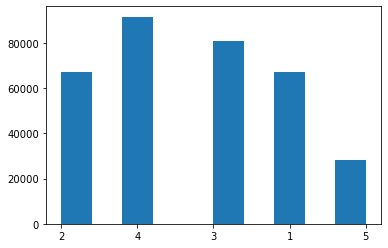

In [ ]:
# Set "lin_class" attributes
roads["lin_class"] = ""

roads.lin_class[roads.linearity >= 0] = "1"  # lowest linearity
roads.lin_class[
    roads.linearity >= np.nanquantile(roads.linearity, 0.20)
] = "2"  # Low-linearity threshold
roads.lin_class[
    roads.linearity >= np.nanquantile(roads.linearity, 0.40)
] = "3"  # Mid-linearity threshold
roads.lin_class[
    roads.linearity >= np.nanquantile(roads.linearity, 0.80)
] = "4"  # High-linearity threshold
roads.lin_class[
    roads.linearity >= np.nanquantile(roads.linearity, 0.95)
] = "5"  # High-linearity threshold

plt.hist(roads["lin_class"])
plt.show()

#### Clip elements (buffer zones)

In [ ]:
# Get clipping extent
crop_ext = gpd.read_file(path.join(input_dir, "AGGR_DHS_buffer.shp"))

# Set CRS
roads = roads.to_crs("EPSG:4326")

# Clip geometries
print("clipping geometries...")
roads_CIV_2 = gpd.overlay(roads, crop_ext, how="intersection")

clipping geometries...


#### Aggregate road data and save temp shapefile

In [ ]:
# Get input data
shp_poly_gdf = gpd.read_file(path.join(input_dir, "AGGR_DHS_buffer_temp_5.shp"))

# Calculate length (m) of edges
roads_CIV_2 = roads_CIV_2.to_crs("EPSG:3857")  # to metric system
roads_CIV_2["Rd_Len"] = roads_CIV_2["geometry"].length  # add col with length

# Aggregate: length (km) of edges, for each buffer zone :
rd_len_data = (roads_CIV_2.groupby("v001").agg("sum")["Rd_Len"]) / 1000

gdf_final_t1 = shp_poly_gdf.merge(rd_len_data, on="v001", how="left")
gdf_final_t1 = gdf_final_t1.rename(columns={"Rd_Len": "RdLenTot"})

# Aggregate: length (km) of edges, by LINEARITY class, for each 5x5km pixel :
rd_len_LI_data = (
    roads_CIV_2.groupby(["v001", "lin_class"]).agg("sum")["Rd_Len"]
) / 1000

rd_len_LI_data_1 = rd_len_LI_data.iloc[
    rd_len_LI_data.index.get_level_values("lin_class") == "1"
]
rd_len_LI_data_2 = rd_len_LI_data.iloc[
    rd_len_LI_data.index.get_level_values("lin_class") == "2"
]
rd_len_LI_data_3 = rd_len_LI_data.iloc[
    rd_len_LI_data.index.get_level_values("lin_class") == "3"
]
rd_len_LI_data_4 = rd_len_LI_data.iloc[
    rd_len_LI_data.index.get_level_values("lin_class") == "4"
]
rd_len_LI_data_5 = rd_len_LI_data.iloc[
    rd_len_LI_data.index.get_level_values("lin_class") == "5"
]

gdf_final_t2 = gdf_final_t1.merge(rd_len_LI_data_1, on="v001", how="left")
gdf_final_t2 = gdf_final_t2.rename(columns={"Rd_Len": "RdLen_LI1"})
gdf_final_t3 = gdf_final_t2.merge(rd_len_LI_data_2, on="v001", how="left")
gdf_final_t3 = gdf_final_t3.rename(columns={"Rd_Len": "RdLen_LI2"})
gdf_final_t4 = gdf_final_t3.merge(rd_len_LI_data_3, on="v001", how="left")
gdf_final_t4 = gdf_final_t4.rename(columns={"Rd_Len": "RdLen_LI3"})
gdf_final_t5 = gdf_final_t4.merge(rd_len_LI_data_4, on="v001", how="left")
gdf_final_t5 = gdf_final_t5.rename(columns={"Rd_Len": "RdLen_LI4"})
gdf_final_t6 = gdf_final_t5.merge(rd_len_LI_data_5, on="v001", how="left")
gdf_final_t6 = gdf_final_t6.rename(columns={"Rd_Len": "RdLen_LI5"})

# Replace NaNs by 0
list_col_names = []
for v in list(gdf_final_t6.columns.to_list()):
    if str(v).startswith("RdLen"):
        list_col_names = list_col_names + [v]

gdf_final = gdf_final_t6.copy()

for v in list_col_names:
    if gdf_final[v].isna().any():
        gdf_final[v] = gdf_final[v].fillna(0)

gdf_final

,v001,prop_10,edge_10,frac_10,prop_30,edge_30,frac_30,prop_50,edge_50,frac_50,...,pc_75_90,pc_b75,built_pix,geometry,RdLenTot,RdLen_LI1,RdLen_LI2,RdLen_LI3,RdLen_LI4,RdLen_LI5
0,1.0,97.287300,1.642417e+05,0.866345,1.356350,9.321825e+04,0.964427,0.246609,22194.821208,0.989369,...,74.822695,13.475177,9.0,"POLYGON ((-3.15356 5.97345, -3.15377 5.96907, ...",80.931200,65.915491,11.664737,2.415456,0.835918,0.099597
1,2.0,13.546798,8.911330e+05,0.790827,79.926108,1.325616e+06,0.484783,0.492611,44334.975369,0.979785,...,26.923077,30.769231,1.0,"POLYGON ((-8.16706 6.46250, -8.16728 6.45813, ...",12.063733,12.063733,0.000000,0.000000,0.000000,0.000000
2,3.0,13.147410,9.274900e+05,0.852884,72.509960,1.950598e+06,0.383876,0.000000,0.000000,0.000000,...,21.935484,35.483871,0.0,"POLYGON ((-8.27965 7.27460, -8.27986 7.27023, ...",45.594455,36.652531,7.962702,0.564346,0.364398,0.050478
3,4.0,86.961870,1.009594e+06,0.549495,2.091021,1.815498e+05,0.937940,1.107011,115129.151292,0.983928,...,26.551724,56.206897,2.0,"POLYGON ((-3.01465 7.73145, -3.01486 7.72709, ...",22.498118,17.402302,5.095816,0.000000,0.000000,0.000000
4,5.0,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,8.028770,87.371414,126.0,"POLYGON ((-5.02274 7.71383, -5.02283 7.71208, ...",189.070631,19.331187,20.917809,37.372213,87.021730,24.427693
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336,348.0,98.282209,1.501840e+05,0.863970,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.000000,46.217105,14.0,"POLYGON ((-5.67087 6.36162, -5.67109 6.35724, ...",36.780442,31.085973,4.865576,0.678314,0.145157,0.005420
337,349.0,85.661765,1.244118e+06,0.500234,9.803922,9.088235e+05,0.879682,0.000000,0.000000,0.000000,...,16.222760,32.445521,7.0,"POLYGON ((-5.23281 6.98753, -5.23303 6.98316, ...",50.610026,13.758455,16.878024,17.008553,2.026587,0.938407
338,350.0,45.312500,1.068750e+06,0.811826,2.343750,1.406250e+05,0.992913,0.000000,0.000000,0.000000,...,55.809674,23.764458,63.0,"POLYGON ((-3.18245 7.13638, -3.18254 7.13464, ...",104.856188,18.352986,18.921388,24.240169,33.543664,9.797981
339,351.0,98.041616,1.938800e+05,0.830987,0.979192,1.057528e+05,0.961448,0.000000,0.000000,0.000000,...,6.990881,46.504559,8.0,"POLYGON ((-6.46786 6.65822, -6.46807 6.65385, ...",59.005977,27.400119,12.945295,12.490090,4.307423,1.863051


In [ ]:
# Save temp file
gdf_final.to_file(path.join(input_dir, "AGGR_DHS_buffer_temp_6.shp"))
print("temp gdf saved")

temp gdf saved


# Climate variables

In [ ]:
# Get input data

shp_poly = path.join(input_dir, "AGGR_DHS_buffer_temp_6.shp")
shp_poly_gdf = gpd.read_file(path.join(input_dir, "AGGR_DHS_buffer_temp_6.shp"))

# Zonal stats : accumulated precipitation (mm)

with rasterio.open(
    path.join(input_dir, "TerraClimate_ppt_2012_bboxciv_acPPT.tif")
) as src:
    affine = src.meta["transform"]
    array = np.where(src.read(1) == src.meta["nodata"], np.nan, src.read(1))

zs = zonal_stats(
    shp_poly, array, affine=affine, all_touched=True, stats="mean"
)  # result will be in 'dictionary' format

# SET RASTER STATS: from DICTIONARY to DATAFRAME (w/ pandas)

zs_df = pd.DataFrame(zs)

# rename columns
zs_df = zs_df.rename(columns={"mean": "ac_ppt16"})

print("zs_df :")
print(zs_df)

print("Look for NaNs:")
print(zs_df.ac_ppt16.isna().value_counts())

if zs_df.ac_ppt16.isna().any() is False:
    gdf_final = pd.concat([gdf_final, zs_df], axis=1)

/Users/vitor/miniconda3/envs/LS_Metrics/lib/python3.8/site-packages/rasterstats/io.py:302: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


zs_df :
        ac_ppt16
0    1617.433322
1    1160.712479
2    1277.799995
3    1200.377780
4    1072.674988
..           ...
336  1032.511122
337  1129.133341
338  1226.424957
339   916.766669
340  1072.674988

[341 rows x 1 columns]
Look for NaNs:
False    341
Name: ac_ppt16, dtype: int64


In [ ]:
# Zonal stats : mean precipitation (mm)

with rasterio.open(
    path.join(input_dir, "TerraClimate_ppt_2012_bboxciv_MEAN.tif")
) as src:
    affine = src.meta["transform"]
    array = np.where(src.read(1) == src.meta["nodata"], np.nan, src.read(1))

zs = zonal_stats(
    shp_poly, array, affine=affine, all_touched=True, stats="mean"
)  # result will be in 'dictionary' format

# SET RASTER STATS: from DICTIONARY to DATAFRAME (w/ pandas)

zs_df = pd.DataFrame(zs)

# rename columns
zs_df = zs_df.rename(columns={"mean": "mn_ppt16"})

print("zs_df :")
print(zs_df)

print("Look for NaNs:")
print(zs_df.mn_ppt16.isna().value_counts())

if zs_df.mn_ppt16.isna().any() is False:
    gdf_final = pd.concat([gdf_final, zs_df], axis=1)

/Users/vitor/miniconda3/envs/LS_Metrics/lib/python3.8/site-packages/rasterstats/io.py:302: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


zs_df :
       mn_ppt16
0    134.786111
1     96.726042
2    106.483334
3    100.031481
4     89.389585
..          ...
336   86.042593
337   94.094444
338  102.202084
339   76.397221
340   89.389585

[341 rows x 1 columns]
Look for NaNs:
False    341
Name: mn_ppt16, dtype: int64


In [ ]:
# Zonal stats : standard deviation of precipitation (mm)

with rasterio.open(
    path.join(input_dir, "TerraClimate_ppt_2012_bboxciv_STD.tif")
) as src:
    affine = src.meta["transform"]
    array = np.where(src.read(1) == src.meta["nodata"], np.nan, src.read(1))

zs = zonal_stats(
    shp_poly, array, affine=affine, all_touched=True, stats="mean"
)  # result will be in 'dictionary' format

# SET RASTER STATS: from DICTIONARY to DATAFRAME (w/ pandas)

zs_df = pd.DataFrame(zs)

# rename columns
zs_df = zs_df.rename(columns={"mean": "std_ppt16"})

print("zs_df :")
print(zs_df)

print("Look for NaNs:")
print(zs_df.std_ppt16.isna().value_counts())

if zs_df.std_ppt16.isna().any() is False:
    gdf_final = pd.concat([gdf_final, zs_df], axis=1)

/Users/vitor/miniconda3/envs/LS_Metrics/lib/python3.8/site-packages/rasterstats/io.py:302: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


zs_df :
     std_ppt16
0    65.901251
1    61.874496
2    69.286409
3    57.573416
4    52.837522
..         ...
336  51.057771
337  50.277286
338  53.734177
339  44.636770
340  52.837522

[341 rows x 1 columns]
Look for NaNs:
False    341
Name: std_ppt16, dtype: int64


In [ ]:
# Zonal stats : mean of maximum temperatures ('tmax')

with rasterio.open(
    path.join(input_dir, "TerraClimate_tmax_2012_bboxciv_MEAN.tif")
) as src:
    affine = src.meta["transform"]
    array = np.where(src.read(1) == src.meta["nodata"], np.nan, src.read(1))

zs = zonal_stats(
    shp_poly, array, affine=affine, all_touched=True, stats="mean"
)  # result will be in 'dictionary' format

# SET RASTER STATS: from DICTIONARY to DATAFRAME (w/ pandas)

zs_df = pd.DataFrame(zs)

# rename columns
zs_df = zs_df.rename(columns={"mean": "mn_tmax16"})

print("zs_df :")
print(zs_df)

print("Look for NaNs:")
print(zs_df.mn_tmax16.isna().value_counts())

if zs_df.mn_tmax16.isna().any() is False:
    gdf_final = pd.concat([gdf_final, zs_df], axis=1)

/Users/vitor/miniconda3/envs/LS_Metrics/lib/python3.8/site-packages/rasterstats/io.py:302: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


zs_df :
     mn_tmax16
0    30.992685
1    31.332812
2    31.682962
3    31.360556
4    31.968540
..         ...
336  30.270647
337  31.591019
338  31.236666
339  30.875462
340  31.968540

[341 rows x 1 columns]
Look for NaNs:
False    341
Name: mn_tmax16, dtype: int64


In [ ]:
# Zonal stats : STD of maximum temperatures ('tmax')

with rasterio.open(
    path.join(input_dir, "TerraClimate_tmax_2012_bboxciv_STD.tif")
) as src:
    affine = src.meta["transform"]
    array = np.where(src.read(1) == src.meta["nodata"], np.nan, src.read(1))

zs = zonal_stats(
    shp_poly, array, affine=affine, all_touched=True, stats="mean"
)  # result will be in 'dictionary' format

# SET RASTER STATS: from DICTIONARY to DATAFRAME (w/ pandas)

zs_df = pd.DataFrame(zs)

# rename columns
zs_df = zs_df.rename(columns={"mean": "std_tmx16"})

print("zs_df :")
print(zs_df)

print("Look for NaNs:")
print(zs_df.std_tmx16.isna().value_counts())

if zs_df.std_tmx16.isna().any() is False:
    gdf_final = pd.concat([gdf_final, zs_df], axis=1)

/Users/vitor/miniconda3/envs/LS_Metrics/lib/python3.8/site-packages/rasterstats/io.py:302: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


zs_df :
     std_tmx16
0     1.791916
1     1.739660
2     1.886310
3     2.301283
4     2.091782
..         ...
336   1.643358
337   1.799232
338   2.065269
339   1.749894
340   2.091782

[341 rows x 1 columns]
Look for NaNs:
False    341
Name: std_tmx16, dtype: int64


In [ ]:
# Save temp file
gdf_final.to_file(path.join(input_dir, "AGGR_DHS_buffer_temp_7.shp"))
print("temp gdf saved")

temp gdf saved


##  Calculate new fields:
### Independent variables derived from land cover classes, road classes and zonal stats in buffer zones

In [ ]:
# Input
shp_poly_gdf = gpd.read_file(path.join(input_dir, "AGGR_DHS_buffer_temp_7.shp"))
shp_poly_gdf.head()

,v001,prop_10,edge_10,frac_10,prop_30,edge_30,frac_30,prop_50,edge_50,frac_50,...,RdLen_LI2,RdLen_LI3,RdLen_LI4,RdLen_LI5,ac_ppt16,mn_ppt16,std_ppt16,mn_tmax16,std_tmx16,geometry
0,1.0,97.287300,1.642417e+05,0.866345,1.356350,9.321825e+04,0.964427,0.246609,22194.821208,0.989369,...,11.664737,2.415456,0.835918,0.099597,1617.433322,134.786111,65.901251,30.992685,1.791916,"POLYGON ((-3.15356 5.97345, -3.15377 5.96907, ..."
1,2.0,13.546798,8.911330e+05,0.790827,79.926108,1.325616e+06,0.484783,0.492611,44334.975369,0.979785,...,0.000000,0.000000,0.000000,0.000000,1160.712479,96.726042,61.874496,31.332812,1.739660,"POLYGON ((-8.16706 6.46250, -8.16728 6.45813, ..."
2,3.0,13.147410,9.274900e+05,0.852884,72.509960,1.950598e+06,0.383876,0.000000,0.000000,0.000000,...,7.962702,0.564346,0.364398,0.050478,1277.799995,106.483334,69.286409,31.682962,1.886310,"POLYGON ((-8.27965 7.27460, -8.27986 7.27023, ..."
3,4.0,86.961870,1.009594e+06,0.549495,2.091021,1.815498e+05,0.937940,1.107011,115129.151292,0.983928,...,5.095816,0.000000,0.000000,0.000000,1200.377780,100.031481,57.573416,31.360556,2.301283,"POLYGON ((-3.01465 7.73145, -3.01486 7.72709, ..."
4,5.0,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,20.917809,37.372213,87.021730,24.427693,1072.674988,89.389585,52.837522,31.968540,2.091782,"POLYGON ((-5.02274 7.71383, -5.02283 7.71208, ..."


In [ ]:
# Calculate road length (km) per built-up pixels (ha):

# Total length / built-up pixel count
shp_poly_gdf["rdTt_BtHa"] = ""
shp_poly_gdf["rdTt_BtHa"][shp_poly_gdf["built_pix"] > 0] = (
    shp_poly_gdf["RdLenTot"] / shp_poly_gdf["built_pix"]
)

# Note: pixels with no built up areas will have blank "rdTt_BtHa" (to avoid division by 0)
# Replace blanks by NaNs:
shp_poly_gdf["rdTt_BtHa"] = shp_poly_gdf.rdTt_BtHa.replace(r"^\s*$", np.nan, regex=True)

shp_poly_gdf.head()

<ipython-input-26-61b5fb6fe726>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shp_poly_gdf["rdTt_BtHa"][shp_poly_gdf['built_pix']>0] = (shp_poly_gdf['RdLenTot']/


,v001,prop_10,edge_10,frac_10,prop_30,edge_30,frac_30,prop_50,edge_50,frac_50,...,RdLen_LI3,RdLen_LI4,RdLen_LI5,ac_ppt16,mn_ppt16,std_ppt16,mn_tmax16,std_tmx16,geometry,rdTt_BtHa
0,1.0,97.287300,1.642417e+05,0.866345,1.356350,9.321825e+04,0.964427,0.246609,22194.821208,0.989369,...,2.415456,0.835918,0.099597,1617.433322,134.786111,65.901251,30.992685,1.791916,"POLYGON ((-3.15356 5.97345, -3.15377 5.96907, ...",8.992356
1,2.0,13.546798,8.911330e+05,0.790827,79.926108,1.325616e+06,0.484783,0.492611,44334.975369,0.979785,...,0.000000,0.000000,0.000000,1160.712479,96.726042,61.874496,31.332812,1.739660,"POLYGON ((-8.16706 6.46250, -8.16728 6.45813, ...",12.063733
2,3.0,13.147410,9.274900e+05,0.852884,72.509960,1.950598e+06,0.383876,0.000000,0.000000,0.000000,...,0.564346,0.364398,0.050478,1277.799995,106.483334,69.286409,31.682962,1.886310,"POLYGON ((-8.27965 7.27460, -8.27986 7.27023, ...",NaN
3,4.0,86.961870,1.009594e+06,0.549495,2.091021,1.815498e+05,0.937940,1.107011,115129.151292,0.983928,...,0.000000,0.000000,0.000000,1200.377780,100.031481,57.573416,31.360556,2.301283,"POLYGON ((-3.01465 7.73145, -3.01486 7.72709, ...",11.249059
4,5.0,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,37.372213,87.021730,24.427693,1072.674988,89.389585,52.837522,31.968540,2.091782,"POLYGON ((-5.02274 7.71383, -5.02283 7.71208, ...",1.500561


In [ ]:
# LINEARITY of roads

# Calculate length of linear roads (classes 4 & 5, defined based on cartographic results)
shp_poly_gdf["rd_len_LI"] = ""
shp_poly_gdf["rd_len_LI"] = shp_poly_gdf["RdLen_LI4"] + shp_poly_gdf["RdLen_LI5"]

# Calculate proportion of linear roads (classes 4 & 5):
# Length classes 4 & 5 / total length
shp_poly_gdf["rd_pc_LI"] = ""
shp_poly_gdf["rd_pc_LI"][shp_poly_gdf["RdLenTot"] > 0] = (
    shp_poly_gdf["rd_len_LI"] / shp_poly_gdf["RdLenTot"]
)

# Note: pixels with no roads will have blank "rd_pc_LI" (to avoid division by 0)
# Replace blanks by NaNs:
shp_poly_gdf["rd_pc_LI"] = shp_poly_gdf.rd_pc_LI.replace(r"^\s*$", np.nan, regex=True)

shp_poly_gdf.head()

<ipython-input-27-9804531af8c7>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shp_poly_gdf["rd_pc_LI"][shp_poly_gdf['RdLenTot']>0] = (shp_poly_gdf['rd_len_LI']/


,v001,prop_10,edge_10,frac_10,prop_30,edge_30,frac_30,prop_50,edge_50,frac_50,...,RdLen_LI5,ac_ppt16,mn_ppt16,std_ppt16,mn_tmax16,std_tmx16,geometry,rdTt_BtHa,rd_len_LI,rd_pc_LI
0,1.0,97.287300,1.642417e+05,0.866345,1.356350,9.321825e+04,0.964427,0.246609,22194.821208,0.989369,...,0.099597,1617.433322,134.786111,65.901251,30.992685,1.791916,"POLYGON ((-3.15356 5.97345, -3.15377 5.96907, ...",8.992356,0.935515,0.011559
1,2.0,13.546798,8.911330e+05,0.790827,79.926108,1.325616e+06,0.484783,0.492611,44334.975369,0.979785,...,0.000000,1160.712479,96.726042,61.874496,31.332812,1.739660,"POLYGON ((-8.16706 6.46250, -8.16728 6.45813, ...",12.063733,0.000000,0.0
2,3.0,13.147410,9.274900e+05,0.852884,72.509960,1.950598e+06,0.383876,0.000000,0.000000,0.000000,...,0.050478,1277.799995,106.483334,69.286409,31.682962,1.886310,"POLYGON ((-8.27965 7.27460, -8.27986 7.27023, ...",NaN,0.414876,0.009099
3,4.0,86.961870,1.009594e+06,0.549495,2.091021,1.815498e+05,0.937940,1.107011,115129.151292,0.983928,...,0.000000,1200.377780,100.031481,57.573416,31.360556,2.301283,"POLYGON ((-3.01465 7.73145, -3.01486 7.72709, ...",11.249059,0.000000,0.0
4,5.0,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,24.427693,1072.674988,89.389585,52.837522,31.968540,2.091782,"POLYGON ((-5.02274 7.71383, -5.02283 7.71208, ...",1.500561,111.449423,0.589459


In [ ]:
# Calculate independent variables derived from land cover classes

# Percentage of high-density pixels (dense built up pixels (last decile) / total built-up pixels)
shp_poly_gdf["pc_HiDen"] = ""
shp_poly_gdf["pc_HiDen"][shp_poly_gdf["built_pix"] > 0] = (
    (
        shp_poly_gdf["prop_19031"]
        + shp_poly_gdf["prop_19032"]
        + shp_poly_gdf["prop_19033"]
        + shp_poly_gdf["prop_19034"]
        +
        # shp_poly_gdf["prop_19041"]+ # class does not exist
        shp_poly_gdf["prop_19042"]
        + shp_poly_gdf["prop_19043"]
        + shp_poly_gdf["prop_19044"]
    )
    / (
        shp_poly_gdf["prop_19011"]
        + shp_poly_gdf["prop_19012"]
        + shp_poly_gdf["prop_19013"]
        + shp_poly_gdf["prop_19014"]
        + shp_poly_gdf["prop_19021"]
        + shp_poly_gdf["prop_19022"]
        + shp_poly_gdf["prop_19023"]
        + shp_poly_gdf["prop_19024"]
        + shp_poly_gdf["prop_19031"]
        + shp_poly_gdf["prop_19032"]
        + shp_poly_gdf["prop_19033"]
        + shp_poly_gdf["prop_19034"]
        +
        # shp_poly_gdf["prop_19041"]+ # class does not exist
        shp_poly_gdf["prop_19042"]
        + shp_poly_gdf["prop_19043"]
        + shp_poly_gdf["prop_19044"]
    )
) * 100

# Note: pixels with no built-up areas will have errors (division by 0)
# Replace by NaNs
shp_poly_gdf["pc_HiDen"][shp_poly_gdf["built_pix"] == 0] = np.nan

print(
    "number of units w/ at least 1 high-density pixel: ",
    np.asarray(shp_poly_gdf[shp_poly_gdf.pc_HiDen > 0]).shape[0],
)

# Percentage of very high-density pixels (dense built up pixels (last decile) / total built-up pixels)
shp_poly_gdf["pc_VHden"] = ""
shp_poly_gdf["pc_VHden"][shp_poly_gdf["built_pix"] > 0] = (
    (  # shp_poly_gdf["prop_19041"]+ # class does not exist
        shp_poly_gdf["prop_19042"]
        + shp_poly_gdf["prop_19043"]
        + shp_poly_gdf["prop_19044"]
    )
    / (
        shp_poly_gdf["prop_19011"]
        + shp_poly_gdf["prop_19012"]
        + shp_poly_gdf["prop_19013"]
        + shp_poly_gdf["prop_19014"]
        + shp_poly_gdf["prop_19021"]
        + shp_poly_gdf["prop_19022"]
        + shp_poly_gdf["prop_19023"]
        + shp_poly_gdf["prop_19024"]
        + shp_poly_gdf["prop_19031"]
        + shp_poly_gdf["prop_19032"]
        + shp_poly_gdf["prop_19033"]
        + shp_poly_gdf["prop_19034"]
        +
        # shp_poly_gdf["prop_19041"]+ # class does not exist
        shp_poly_gdf["prop_19042"]
        + shp_poly_gdf["prop_19043"]
        + shp_poly_gdf["prop_19044"]
    )
) * 100

# Note: pixels with no built-up areas will have errors (division by 0)
# Replace by NaNs
shp_poly_gdf["pc_VHden"][shp_poly_gdf["built_pix"] == 0] = np.nan

print(
    "number of units w/ at least 1 very-high density pixel: ",
    np.asarray(shp_poly_gdf[shp_poly_gdf.pc_VHden > 0]).shape[0],
)


# Percentage of precarious areas I ('prop_1' / 'prop_190')
shp_poly_gdf["prop_Prec"] = ""
shp_poly_gdf["prop_Prec"][shp_poly_gdf["built_pix"] > 0] = (
    shp_poly_gdf["prop_1"] / shp_poly_gdf["prop_190"]
) * 100

# Replace by NaNs
shp_poly_gdf["prop_Prec"][shp_poly_gdf["built_pix"] == 0] = np.nan

print(
    "number of units w/ at least 1 precarious area pixel (type I): ",
    np.asarray(shp_poly_gdf[shp_poly_gdf.prop_Prec > 0]).shape[0],
)


# Percentage of precarious areas II (n pixels[density factor > light factor] / total n buit-up pixels)
shp_poly_gdf["pc_PrecAr"] = ""
shp_poly_gdf["pc_PrecAr"][shp_poly_gdf["built_pix"] > 0] = (
    (
        shp_poly_gdf["prop_19021"]
        + shp_poly_gdf["prop_19031"]
        + shp_poly_gdf["prop_19032"]
        +
        # shp_poly_gdf["prop_19041"]+ # class does not exist
        shp_poly_gdf["prop_19042"]
        + shp_poly_gdf["prop_19043"]
    )
    / (
        shp_poly_gdf["prop_19011"]
        + shp_poly_gdf["prop_19012"]
        + shp_poly_gdf["prop_19013"]
        + shp_poly_gdf["prop_19014"]
        + shp_poly_gdf["prop_19021"]
        + shp_poly_gdf["prop_19022"]
        + shp_poly_gdf["prop_19023"]
        + shp_poly_gdf["prop_19024"]
        + shp_poly_gdf["prop_19031"]
        + shp_poly_gdf["prop_19032"]
        + shp_poly_gdf["prop_19033"]
        + shp_poly_gdf["prop_19034"]
        +
        # shp_poly_gdf["prop_19041"]+ # class does not exist
        shp_poly_gdf["prop_19042"]
        + shp_poly_gdf["prop_19043"]
        + shp_poly_gdf["prop_19044"]
    )
) * 100

# Note: pixels with no built-up areas will have errors (division by 0)
# Replace by NaNs
shp_poly_gdf["pc_PrecAr"][shp_poly_gdf["built_pix"] == 0] = np.nan

print(
    "number of units w/ at least 1 precarious area pixel (type II): ",
    np.asarray(shp_poly_gdf[shp_poly_gdf.pc_PrecAr > 0]).shape[0],
)

# Percentage of VERY precarious areas (n pixels[density factor >> light factor] / total n buit-up pixels)
shp_poly_gdf["pc_VPrcAr"] = ""
shp_poly_gdf["pc_VPrcAr"][shp_poly_gdf["built_pix"] > 0] = (
    (
        shp_poly_gdf["prop_19031"]
        +
        # shp_poly_gdf["prop_19041"]+ # class does not exist
        shp_poly_gdf["prop_19042"]
    )
    / (
        shp_poly_gdf["prop_19011"]
        + shp_poly_gdf["prop_19012"]
        + shp_poly_gdf["prop_19013"]
        + shp_poly_gdf["prop_19014"]
        + shp_poly_gdf["prop_19021"]
        + shp_poly_gdf["prop_19022"]
        + shp_poly_gdf["prop_19023"]
        + shp_poly_gdf["prop_19024"]
        + shp_poly_gdf["prop_19031"]
        + shp_poly_gdf["prop_19032"]
        + shp_poly_gdf["prop_19033"]
        + shp_poly_gdf["prop_19034"]
        +
        # shp_poly_gdf["prop_19041"]+ # class does not exist
        shp_poly_gdf["prop_19042"]
        + shp_poly_gdf["prop_19043"]
        + shp_poly_gdf["prop_19044"]
    )
) * 100

# Note: pixels with no built-up areas will have errors (division by 0)
# Replace by NaNs
shp_poly_gdf["pc_VPrcAr"][shp_poly_gdf["built_pix"] == 0] = np.nan

print(
    "number of units w/ at least 1 VERY precarious area pixel: ",
    np.asarray(shp_poly_gdf[shp_poly_gdf.pc_VPrcAr > 0]).shape[0],
)

# Percentage of WELL ILLUMINATED areas (pixels with illum. group > 2 / total pixels)
shp_poly_gdf["pc_WelIll"] = ""
shp_poly_gdf["pc_WelIll"][shp_poly_gdf["built_pix"] > 0] = (
    (
        shp_poly_gdf["prop_19013"]
        + shp_poly_gdf["prop_19014"]
        + shp_poly_gdf["prop_19023"]
        + shp_poly_gdf["prop_19024"]
        + shp_poly_gdf["prop_19033"]
        + shp_poly_gdf["prop_19034"]
        + shp_poly_gdf["prop_19043"]
        + shp_poly_gdf["prop_19044"]
    )
    / (
        shp_poly_gdf["prop_19011"]
        + shp_poly_gdf["prop_19012"]
        + shp_poly_gdf["prop_19013"]
        + shp_poly_gdf["prop_19014"]
        + shp_poly_gdf["prop_19021"]
        + shp_poly_gdf["prop_19022"]
        + shp_poly_gdf["prop_19023"]
        + shp_poly_gdf["prop_19024"]
        + shp_poly_gdf["prop_19031"]
        + shp_poly_gdf["prop_19032"]
        + shp_poly_gdf["prop_19033"]
        + shp_poly_gdf["prop_19034"]
        +
        # shp_poly_gdf["prop_19041"]+ # class does not exist
        shp_poly_gdf["prop_19042"]
        + shp_poly_gdf["prop_19043"]
        + shp_poly_gdf["prop_19044"]
    )
) * 100

# Note: pixels with no built-up areas will have errors (division by 0)
# Replace by NaNs
shp_poly_gdf["pc_WelIll"][shp_poly_gdf["built_pix"] == 0] = np.nan

print(
    "number of units w/ at least 1 well-illuminated area area pixel: ",
    np.asarray(shp_poly_gdf[shp_poly_gdf.pc_WelIll > 0]).shape[0],
)

# Percentage of VERY WELL ILLUMINATED areas (pixels with illum. group > 3 / total pixels)
shp_poly_gdf["pc_VWelIl"] = ""
shp_poly_gdf["pc_VWelIl"][shp_poly_gdf["built_pix"] > 0] = (
    (
        shp_poly_gdf["prop_19014"]
        + shp_poly_gdf["prop_19024"]
        + shp_poly_gdf["prop_19034"]
        + shp_poly_gdf["prop_19044"]
    )
    / (
        shp_poly_gdf["prop_19011"]
        + shp_poly_gdf["prop_19012"]
        + shp_poly_gdf["prop_19013"]
        + shp_poly_gdf["prop_19014"]
        + shp_poly_gdf["prop_19021"]
        + shp_poly_gdf["prop_19022"]
        + shp_poly_gdf["prop_19023"]
        + shp_poly_gdf["prop_19024"]
        + shp_poly_gdf["prop_19031"]
        + shp_poly_gdf["prop_19032"]
        + shp_poly_gdf["prop_19033"]
        + shp_poly_gdf["prop_19034"]
        +
        # shp_poly_gdf["prop_19041"]+ # class does not exist
        shp_poly_gdf["prop_19042"]
        + shp_poly_gdf["prop_19043"]
        + shp_poly_gdf["prop_19044"]
    )
) * 100

# Note: pixels with no built-up areas will have errors (division by 0)
# Replace by NaNs
shp_poly_gdf["pc_VWelIl"][shp_poly_gdf["built_pix"] == 0] = np.nan

print(
    "number of units w/ at least 1 well-illuminated area area pixel: ",
    np.asarray(shp_poly_gdf[shp_poly_gdf.pc_VWelIl > 0]).shape[0],
)

number of units w/ at least 1 high-density pixel:  155
number of units w/ at least 1 very-high density pixel:  46
number of units w/ at least 1 precarious area pixel (type I):  192
number of units w/ at least 1 precarious area pixel (type II):  192
number of units w/ at least 1 VERY precarious area pixel:  25
number of units w/ at least 1 well-illuminated area area pixel:  157
number of units w/ at least 1 well-illuminated area area pixel:  97


<ipython-input-28-7a7109786db1>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shp_poly_gdf["pc_HiDen"][shp_poly_gdf["built_pix"]>0] = ((shp_poly_gdf["prop_19031"]+
<ipython-input-28-7a7109786db1>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shp_poly_gdf["pc_HiDen"][shp_poly_gdf["built_pix"]==0] = np.nan
<ipython-input-28-7a7109786db1>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shp_poly_gdf["pc_VHden"][shp_poly_gdf["built

In [ ]:
# Save file
shp_poly_gdf.to_file(path.join(dest_dir, "AGGR_DHS_buffer_4stats.shp"))
print("final gdf saved")

final gdf saved
